# $\mathrm{MGLYOX}$ (Methylglyoxal)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3COCOH" 
nice_name = "Methylglyoxal"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println(unique(T1s))

[298.0, 293.0, 295.0, 387.0, 296.0, 248.0, 273.0]


In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

11512


4×7 DataFrame
 Row │ variable   mean           min          median       max         nmissin ⋯
     │ Symbol     Float64        Real         Float64      Real        Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ          353.817        200.0        354.42       493.88              ⋯
   2 │ σ            3.66018e-20    4.276e-24    2.621e-20    3.38e-19
   3 │ T          296.498        293.0        296.0        298.0
   4 │ source_id    9.31723        1            8.0         16
                                                               2 columns omitted

In [8]:
#idxs_298 = [i for i ∈ 1:size(T1s, 1) if T1s[i] == 298.0]
#unique(source_idx[idxs_298])
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

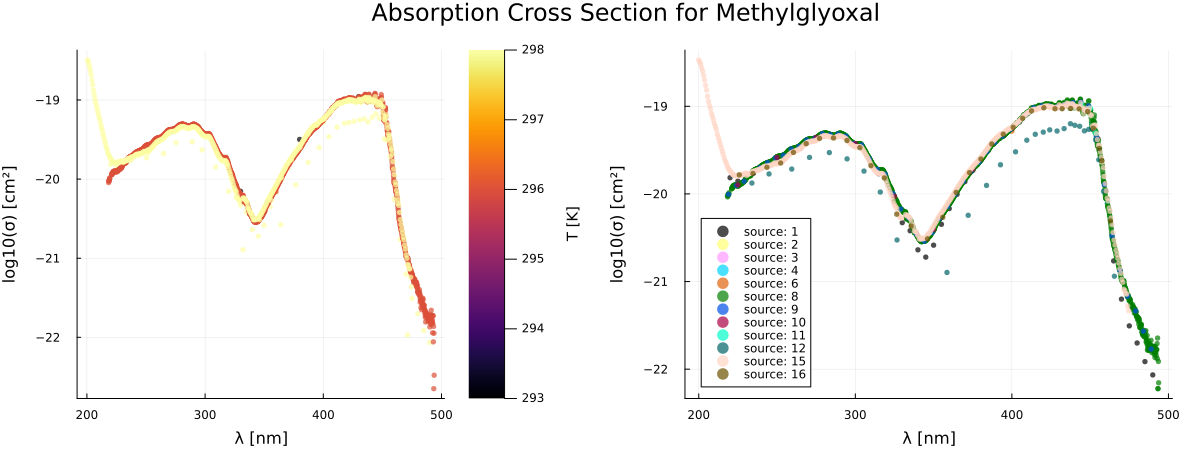

In [9]:
nskip = 5

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        log10.(df_g.σ[1:nskip:end]),
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="log10(σ) [cm²]",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Absorption Cross Section for $(nice_name)",)

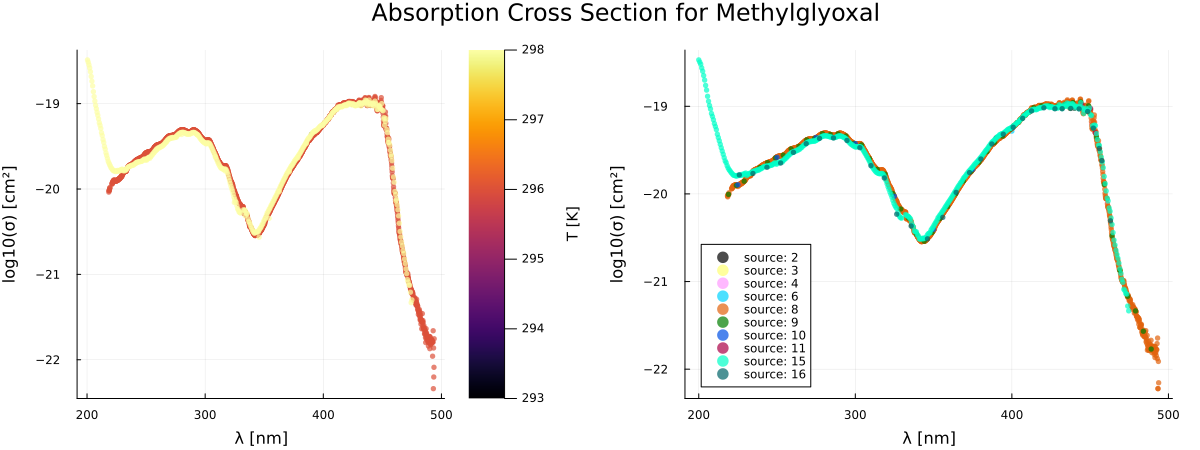

In [10]:
# we need to drop source 1 and 12 
df = df[df.source_id .!= 1 .&& df.source_id .!= 12, :]

nskip = 5

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        log10.(df_g.σ[1:nskip:end]),
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="log10(σ) [cm²]",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Absorption Cross Section for $(nice_name)",)

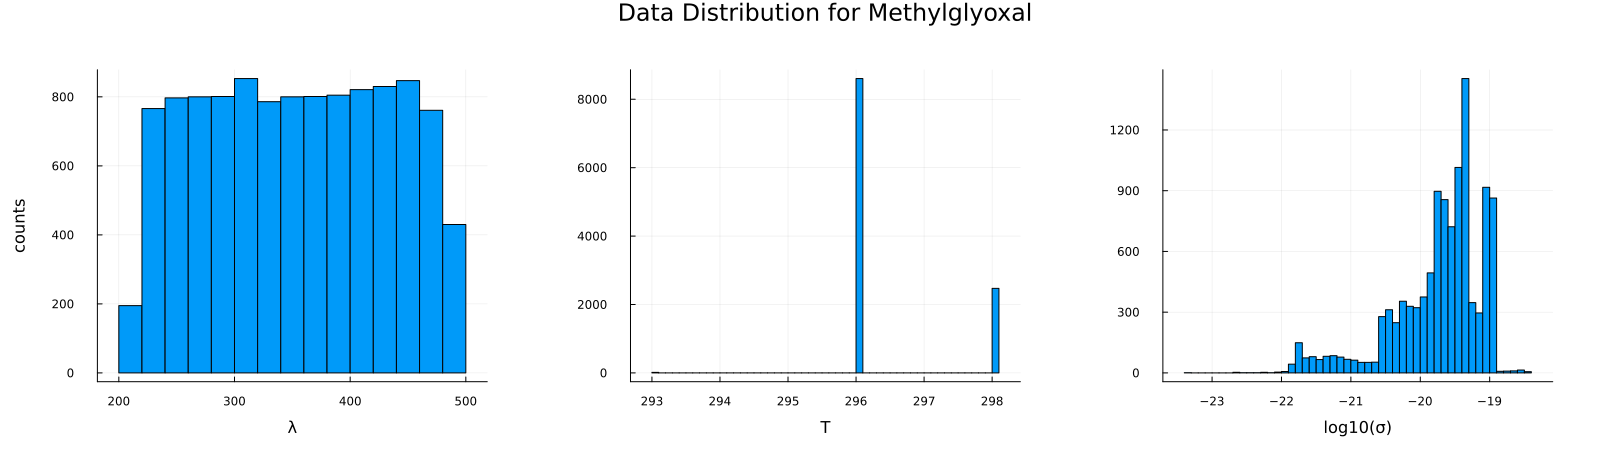

In [11]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [12]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [13]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [14]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

10776×3 DataFrame
   Row │ λ        σ          T       
       │ Float64  Float64    Float64 
───────┼─────────────────────────────
     1 │  290.0   4.88e-20     293.0
     2 │  300.0   3.52e-20     293.0
     3 │  310.0   2.44e-20     293.0
     4 │  320.0   1.65e-20     293.0
     5 │  330.0   7.0e-21      293.0
     6 │  340.0   3.2e-21      293.0
     7 │  350.0   4.8e-21      293.0
     8 │  360.0   8.0e-21      293.0
     9 │  370.0   1.8e-20      293.0
    10 │  380.0   3.17e-20     293.0
    11 │  390.0   4.35e-20     293.0
   ⋮   │    ⋮         ⋮         ⋮
 10767 │  455.83  3.3e-20      298.0
 10768 │  456.29  3.32e-20     298.0
 10769 │  456.9   2.79e-20     298.0
 10770 │  457.35  2.52e-20     298.0
 10771 │  458.87  1.62e-20     298.0
 10772 │  460.16  1.03e-20     298.0
 10773 │  460.54  9.04e-21     298.0
 10774 │  461.45  7.26e-21     298.0
 10775 │  462.97  4.93e-21     298.0
 10776 │  463.43  4.39e-21     298.0
                   10755 rows omitted

In [15]:
df_unique = filter_outliers(df_unique, log10.(df_unique.σ))
println(nrow(df_unique))

df_unique = df_unique[df_unique.T .== 298.0, :]

10079


2305×3 DataFrame
  Row │ λ        σ            T       
      │ Float64  Float64      Float64 
──────┼───────────────────────────────
    1 │  225.0   1.449e-20      298.0
    2 │  230.0   1.6035e-20     298.0
    3 │  235.0   1.8115e-20     298.0
    4 │  240.0   2.0055e-20     298.0
    5 │  245.0   2.197e-20      298.0
    6 │  250.0   2.411e-20      298.0
    7 │  255.0   2.6945e-20     298.0
    8 │  260.0   3.09e-20       298.0
    9 │  265.0   3.474e-20      298.0
   10 │  270.0   4.0445e-20     298.0
   11 │  275.0   4.2165e-20     298.0
  ⋮   │    ⋮          ⋮          ⋮
 2296 │  455.83  3.3e-20        298.0
 2297 │  456.29  3.32e-20       298.0
 2298 │  456.9   2.79e-20       298.0
 2299 │  457.35  2.52e-20       298.0
 2300 │  458.87  1.62e-20       298.0
 2301 │  460.16  1.03e-20       298.0
 2302 │  460.54  9.04e-21       298.0
 2303 │  461.45  7.26e-21       298.0
 2304 │  462.97  4.93e-21       298.0
 2305 │  463.43  4.39e-21       298.0
                     2284 rows omitted

In [16]:
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
# T_idxs = representative_rand_sample(df_unique.λ, 5, 500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

# idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs,σ_idxs)))
idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(1418, 3)


200.0

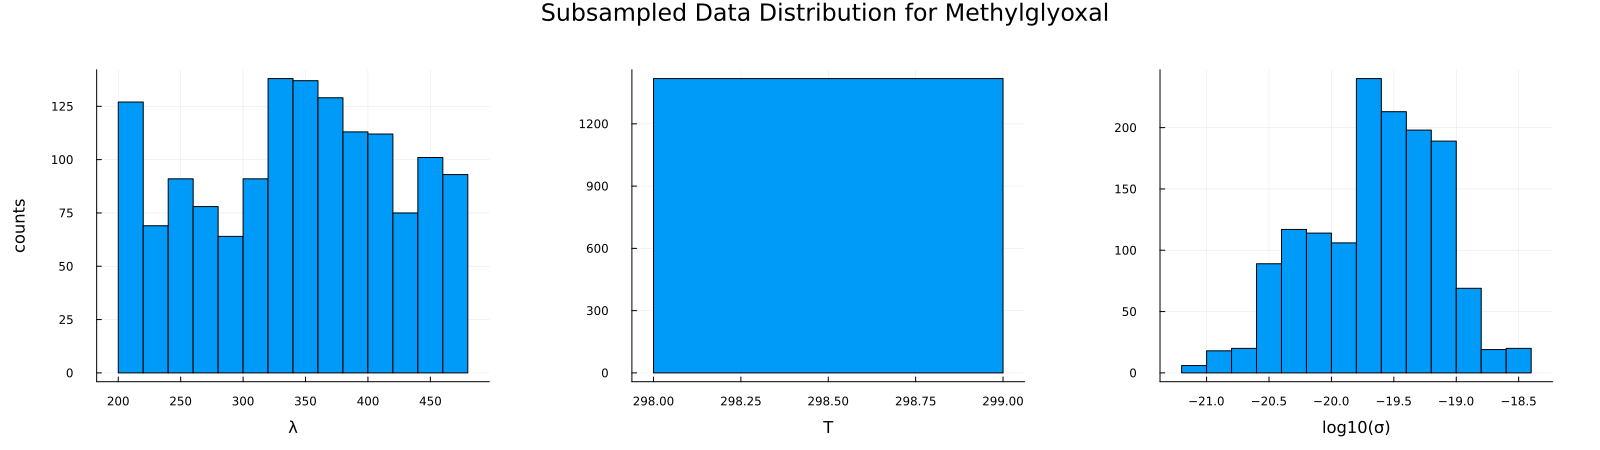

In [17]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

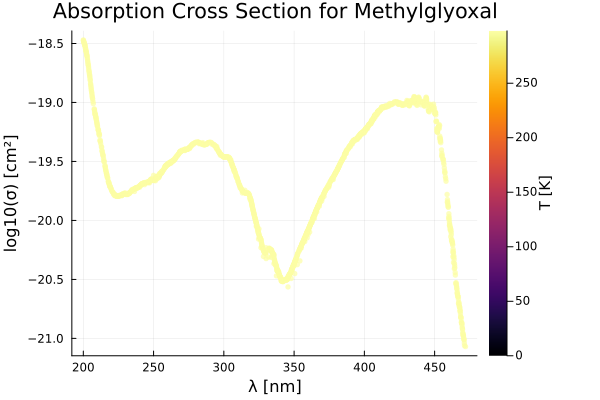

In [18]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [19]:
train_frac = 0.9
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1276


In [20]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

142-element Vector{Float64}:
 -19.65364702554936
 -19.347753658996677
 -20.30715308072277
 -20.374687549038327
 -19.723538195826755
 -19.510041520575164
 -19.201349354554733
 -20.51427857351842
 -19.82102305270683
 -20.106793246940153
 -19.481486060122112
 -20.129596094720974
 -20.32605800136591
   ⋮
 -18.97881070093006
 -19.33818731446274
 -19.657577319177793
 -18.49349496759513
 -19.068542129310995
 -19.756961951313706
 -19.191789027075778
 -20.18775530319963
 -18.955264302549494
 -20.272458742971445
 -19.00436480540245
 -19.835647144215564

In [50]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
# ℓ_T = std(Xtrain.T)/κ
println("ℓ_λ: ",ℓ_λ)
# println("ℓ_T: ",ℓ_T)


# compute variance parameters
SNR = 5
σf² = (var(ytrain))/2
σₙ² = (sqrt(σf²)/SNR)^2
# σₙ² = 10.0
println("σf²: ", σf²)
println("σₙ²: ", σₙ²)

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ)) #, ℓ_T=positive(ℓ_T))

function mykernel(θ::NamedTuple)
    # return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ,])
end

ℓ_λ: 78.35867399099568
σf²: 0.1308512657991197
σₙ²: 0.005234050631964789


mykernel (generic function with 1 method)

In [51]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.0336940902659792, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.361296670729158, exp, 1.4901161193847656e-8)), 
  σ² = 0.005234050631964789, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [52]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     2.258100e+03     5.893896e+03
 * time: 0.0001480579376220703
     1     1.035603e+03     2.633285e+03
 * time: 3.1867098808288574
     2    -1.597243e+03     4.988149e+02
 * time: 3.820719003677368
     3    -2.641954e+03     4.004009e+02
 * time: 4.810971975326538
     4    -3.074645e+03     3.433161e+02
 * time: 5.791157960891724
     5    -3.198040e+03     2.054869e+02
 * time: 6.181313991546631
     6    -3.251274e+03     1.068383e+02
 * time: 6.642506837844849
     7    -3.258658e+03     5.287210e+01
 * time: 7.2644219398498535
     8    -3.265434e+03     6.075509e+01
 * time: 7.834735870361328
     9    -3.278953e+03     2.053233e+02
 * time: 8.401742935180664
    10    -3.287358e+03     2.430639e+01
 * time: 9.086395025253296
    11    -3.288003e+03     1.008345e+01
 * time: 9.673949003219604
    12    -3.288130e+03     4.301991e+00
 * time: 10.241227865219116
    13    -3.288143e+03     3.033090e-01
 * time: 10.883748054504395

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @579 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @427 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [53]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.6205790444003556, 2.3694064095604666, -8.42966073239216],
 minimum = -3288.14383059499,
 iterations = 585,
 converged = false,)

In [54]:
fp = fitted_params(mach)

(θ_best = [:σf² => 37.35919420723511, :ℓ_λ => 10.691044313462585],
 σ² = 0.00021831043959492675,)

In [55]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


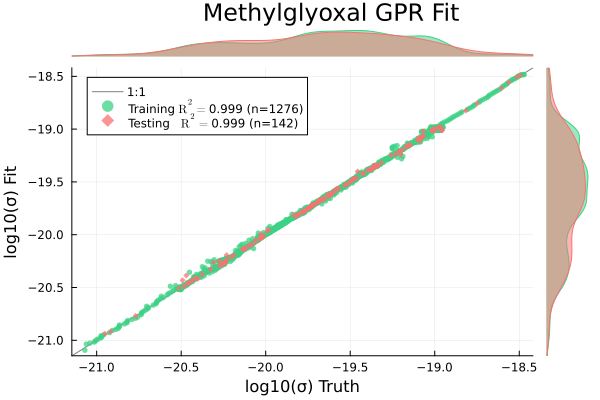

In [56]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


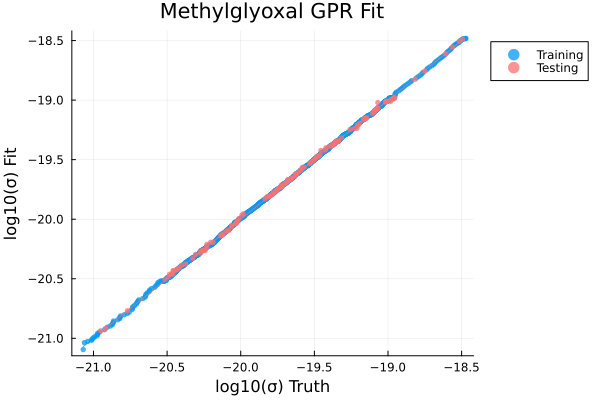

In [57]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


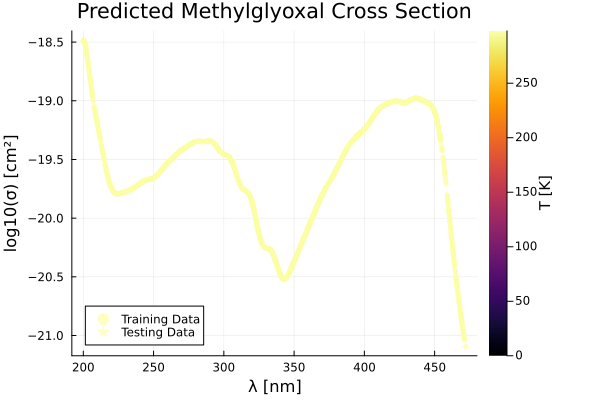

In [58]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

200.0
472.0


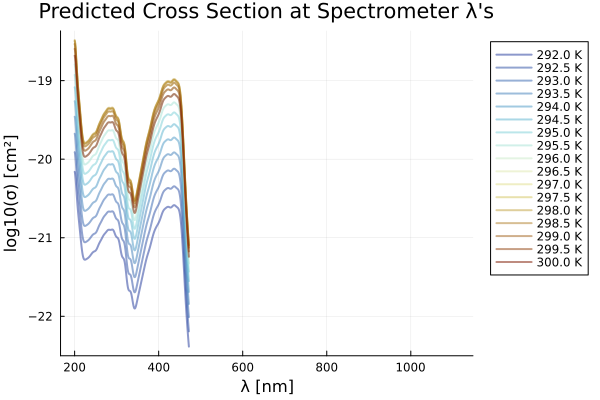

In [59]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

function predict_logσ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = predict_mean(mach, Xout)
    
    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    res[idxs] .= NaN 
    return res
end



p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

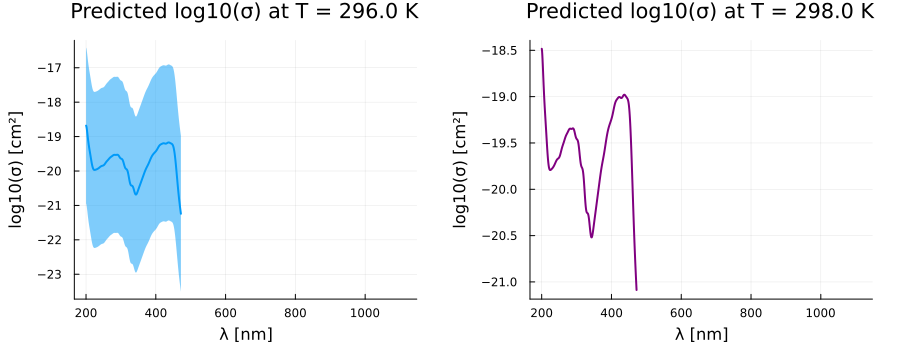

In [60]:
function predict_logσ_wΔ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = MLJ.predict(mach, Xout)

    logσ = mean.(res)
    Δlogσ = std.(res)

    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    logσ[idxs] .= NaN 
    Δlogσ[idxs] .= NaN 
    return logσ, Δlogσ
    #return res
end

Tplot = 296.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 